In [ ]:
# Install Apache Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download and install Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Install PySpark
!pip install -q pyspark==3.5.0

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# For Google Colab specific setup
!pip install -q findspark

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("ML with Spark MLlib") \
    .getOrCreate()

print("Spark Version:", spark.version)


Spark Version: 3.5.0


In [ ]:
# =============================================================================
# CELL 1: MOUNT GOOGLE DRIVE
# =============================================================================
print("\n" + "=" * 80)
print("☁️ MOUNTING GOOGLE DRIVE")
print("=" * 80)

from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted!")


☁️ MOUNTING GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted!


In [ ]:
# =============================================================================
# CELL 2: LOAD CLEANED DATA WITH FEATURES FROM GOOGLE DRIVE
# =============================================================================
print("\n" + "=" * 80)
print("📥 LOADING CLEANED DATA WITH FEATURES FROM GOOGLE DRIVE")
print("=" * 80)

# Path to your cleaned data with all features
DATA_PATH = "/content/drive/MyDrive/BigDataProject/cleaned_data.csv/cleaned_data.csv/"

# Ensure SparkSession is initialized if not already defined (workaround for inconsistent execution state)
from pyspark.sql import SparkSession
if 'spark' not in locals() or spark is None:
    print("SparkSession not found, initializing a new one...")
    spark = SparkSession.builder \
        .appName("ML with Spark MLlib") \
        .getOrCreate()

df = spark.read.csv(
    DATA_PATH,
    header=True,
    inferSchema=True
)

# Preview data
df.show(5)
df.printSchema()


📥 LOADING CLEANED DATA WITH FEATURES FROM GOOGLE DRIVE
+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------------+-------------+----------------+--------------+-----------+--------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+-----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+-----------------+------------+---------------+-------------------+--------------------+-------------+--------------+--------------------------+--------------+--------------------+---------------+---------------+----------------+--------------+--------------------+-

In [ ]:
# =============================================================================
# CELL 3: FEATURE SELECTION FOR CLUSTERING
# =============================================================================

from pyspark.sql.functions import col

feature_cols = [
    "days_since_last_order",
    "order_frequency_rate",
    "total_lifetime_value",
    "average_order_value",
    "shipping_delay",
    "order_to_ship_days",
    "actual_shipping_days",
    "Late_delivery_risk",
    "discount_percentage",
    "has_discount",
    "discount_impact",
    "profit_margin"
]

# Keep only required features and drop rows with missing values
ml_df = df.select(feature_cols).dropna()

print("✅ Features selected for clustering:")
print(feature_cols)

✅ Features selected for clustering:
['days_since_last_order', 'order_frequency_rate', 'total_lifetime_value', 'average_order_value', 'shipping_delay', 'order_to_ship_days', 'actual_shipping_days', 'Late_delivery_risk', 'discount_percentage', 'has_discount', 'discount_impact', 'profit_margin']


In [ ]:
# =============================================================================
# CELL 4: FEATURE VECTOR ASSEMBLY
# =============================================================================

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

assembled_df = assembler.transform(ml_df)

assembled_df.select("features_raw").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|features_raw                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|[3682.0,0.0,499.9500122,499.9500122,2.0,6.0,6.0,1.0,27.502750863645232,1.0,0.0550054992077866,0.3194119382001687]                           |
|[3196.0,1.1368421052631579,3537.68009381,196.53778298944445,0.0,4.0,4.0,0.0,20.0,1.0,0.1,0.1125]                                            |
|[3119.0,0.9782608695652175,3537.68009381,196.53778298944445,0.0,0.0,0.0,0.0,17.001132785477495,1.0,0.17001132785477496,0.009967330823252754]|
|[3196.0,1.1368421052631579,3537.68009381,196.53778298944445,0.0,4.0,4.0,0.0,16.5,1.0,0.055,0.4441333516666667]                              |

In [ ]:
# =============================================================================
# CELL 5: FEATURE STANDARDIZATION
# =============================================================================

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

scaled_df.select("features").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.6322684677178573,-0.16033148081435417,-1.7419091026294906,3.750191291951726,0.9619214948071205,1.5411174313919405,1.5411174313919405,0.9076581960762586,0.2532649452498858,0.24252428377144972,-0.6571879938016021,0.5018758301800303]          |
|[-0.94968797915

In [ ]:
# =============================================================================
# CELL 6: HYPERPARAMETER TUNING WITH SILHOUETTE SCORE
# =============================================================================

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol="features",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

k_values = [3, 4, 5, 6, 7, 8]
max_iter_values = [20, 40]

best_score = -1
best_model = None
best_params = {}

for k in k_values:
    for max_iter in max_iter_values:
        kmeans = KMeans(
            k=k,
            maxIter=max_iter,
            seed=42,
            featuresCol="features"
        )

        model = kmeans.fit(scaled_df)
        predictions = model.transform(scaled_df)
        silhouette = evaluator.evaluate(predictions)

        print(f"k={k}, maxIter={max_iter}, silhouette={silhouette:.4f}")

        if silhouette > best_score:
            best_score = silhouette
            best_model = model
            best_params = {"k": k, "maxIter": max_iter}

print("\n✅ Best Model Parameters:", best_params)
print("✅ Best Silhouette Score:", best_score)

k=3, maxIter=20, silhouette=0.2572
k=3, maxIter=40, silhouette=0.2589
k=4, maxIter=20, silhouette=0.3778
k=4, maxIter=40, silhouette=0.3778
k=5, maxIter=20, silhouette=0.3301
k=5, maxIter=40, silhouette=0.3301
k=6, maxIter=20, silhouette=0.3421
k=6, maxIter=40, silhouette=0.3421
k=7, maxIter=20, silhouette=0.2856
k=7, maxIter=40, silhouette=0.2857
k=8, maxIter=20, silhouette=0.2582
k=8, maxIter=40, silhouette=0.2582

✅ Best Model Parameters: {'k': 4, 'maxIter': 20}
✅ Best Silhouette Score: 0.37778971039071507


# **Plotting K Silhouette Scores**

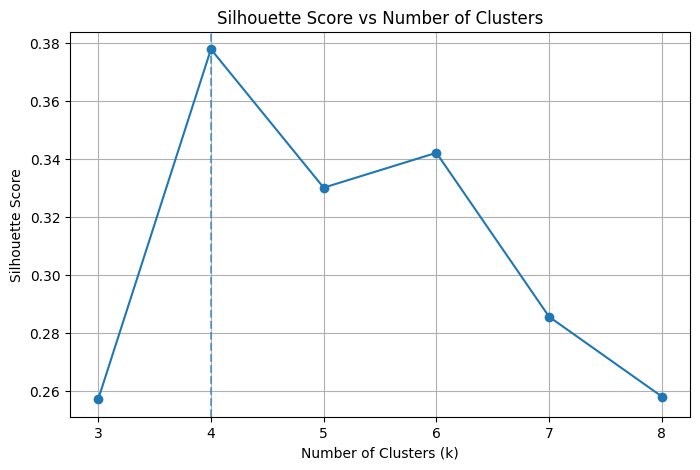

In [ ]:
# =============================================================================
# CELL 7: SILHOUETTE SCORE VS K PLOT
# =============================================================================

import matplotlib.pyplot as plt

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        k=k,
        maxIter=best_params["maxIter"],
        seed=42,
        featuresCol="features"
    )
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.axvline(x=4, linestyle='--', alpha=0.6)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()

In [ ]:
# =============================================================================
# CELL 8: FINAL CLUSTER ASSIGNMENT
# =============================================================================

final_predictions = best_model.transform(scaled_df)

final_predictions.select("features", "prediction").show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.63226846771785...|         2|
|[-0.9496879791586...|         0|
|[-1.2003271693016...|         0|
|[-0.9496879791586...|         0|
|[-1.0180441219249...|         0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# =============================================================================
# CELL 9: EXPORT DATA WITH CLUSTER LABELS
# =============================================================================

# Attach cluster labels to original feature dataframe
clustered_df = final_predictions.select(
    *feature_cols,
    col("prediction").alias("cluster")
)

# Save clustered dataset for visualization
OUTPUT_PATH = "/content/drive/MyDrive/BigDataProject/clustered_customers.csv"

clustered_df.coalesce(1).write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(OUTPUT_PATH)

print("✅ Clustered dataset exported with cluster labels.")


✅ Clustered dataset exported with cluster labels.


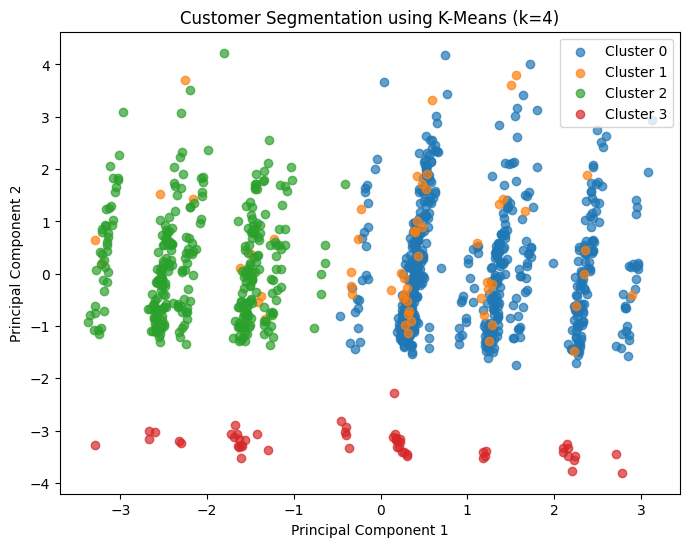

In [ ]:
# =============================================================================
# CELL 10: CLUSTER VISUALIZATION on a sample - PCA + K-MEANS CLUSTERS
# =============================================================================

from pyspark.sql.functions import rand
from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt
# Random subset used internally for visualization clarity
viz_df = final_predictions.orderBy(rand()).limit(1000)


# Apply PCA
pca_viz = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_viz_model = pca_viz.fit(viz_df)
pca_viz_df = pca_viz_model.transform(viz_df)

# Convert to Pandas
plot_df = pca_viz_df.select("pca_features", "prediction").toPandas()
plot_df[['pc1', 'pc2']] = pd.DataFrame(
    plot_df['pca_features'].tolist(),
    index=plot_df.index
)

# Plot clusters
plt.figure(figsize=(8, 6))
for c in sorted(plot_df['prediction'].unique()):
    subset = plot_df[plot_df['prediction'] == c]
    plt.scatter(
        subset['pc1'],
        subset['pc2'],
        alpha=0.7,
        label=f"Cluster {c}"
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation using K-Means (k=4)")
plt.legend()
plt.show()

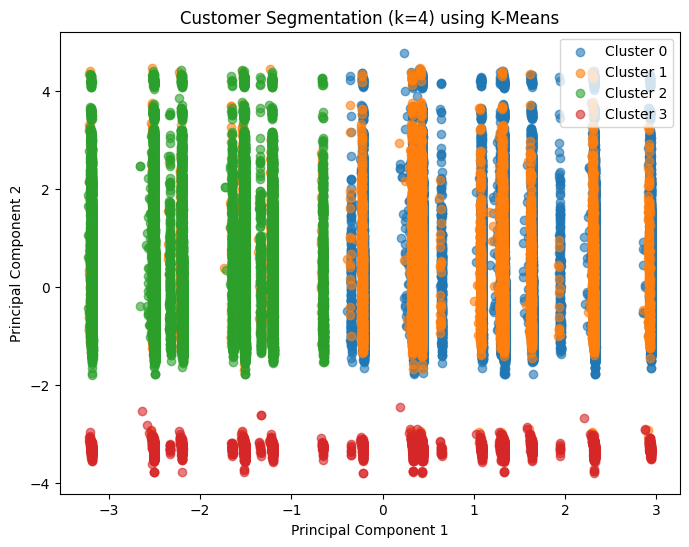

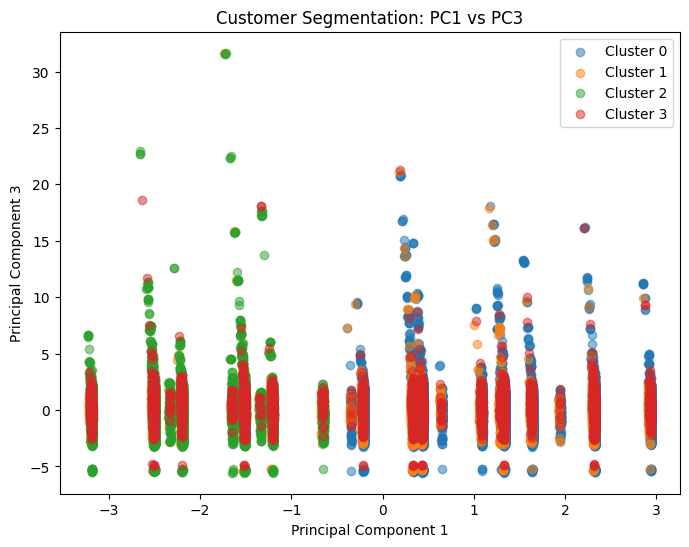

In [ ]:
# =============================================================================
# CELL 11: VISUALIZATION CELL on full data: PCA + CLUSTER SCATTER PLOT
# =============================================================================

from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Apply PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(final_predictions)
pca_df = pca_model.transform(final_predictions)

# Convert to Pandas for plotting
plot_df = pca_df.select("pca_features", "prediction").toPandas()
plot_df[['pc1', 'pc2']] = pd.DataFrame(plot_df['pca_features'].tolist(), index=plot_df.index)

# Plot
plt.figure(figsize=(8,6))
for c in sorted(plot_df['prediction'].unique()):
    subset = plot_df[plot_df['prediction'] == c]
    plt.scatter(subset['pc1'], subset['pc2'], label=f"Cluster {c}", alpha=0.6)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation (k=4) using K-Means")
plt.legend()
plt.show()
# Alternative PCA view to inspect separation beyond PC1–PC2
pca_alt = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_alt_model = pca_alt.fit(final_predictions)
pca_alt_df = pca_alt_model.transform(final_predictions)

plot_df_alt = pca_alt_df.select("pca_features", "prediction").toPandas()
plot_df_alt[['pc1', 'pc2', 'pc3']] = pd.DataFrame(
    plot_df_alt['pca_features'].tolist(),
    index=plot_df_alt.index
)

plt.figure(figsize=(8, 6))
for c in sorted(plot_df_alt['prediction'].unique()):
    subset = plot_df_alt[plot_df_alt['prediction'] == c]
    plt.scatter(subset['pc1'], subset['pc3'], alpha=0.5, label=f"Cluster {c}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 3")
plt.title("Customer Segmentation: PC1 vs PC3")
plt.legend()
plt.show()

In [ ]:
from pyspark.ml.feature import PCA
import pandas as pd

# Fit PCA with 6 components
pca = PCA(k=6, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(final_predictions)

# Extract principal component matrix
pc_matrix = pca_model.pc.toArray()   # shape: [n_features, n_components]

# Map back to original feature names
feature_names = [
    "days_since_last_order",
    "order_frequency_rate",
    "total_lifetime_value",
    "average_order_value",
    "shipping_delay",
    "order_to_ship_days",
    "actual_shipping_days",
    "Late_delivery_risk",
    "discount_percentage",
    "has_discount",
    "discount_impact",
    "profit_margin"
]

loadings_df = pd.DataFrame(pc_matrix,
                           index=feature_names,
                           columns=[f"PC{i+1}" for i in range(pc_matrix.shape[1])])

print(loadings_df)

                            PC1       PC2       PC3       PC4       PC5  \
days_since_last_order -0.001503  0.052693  0.645346 -0.167717 -0.018463   
order_frequency_rate  -0.003661  0.018153  0.488223  0.185610  0.050744   
total_lifetime_value   0.000621  0.041643  0.535027  0.391431 -0.019091   
average_order_value   -0.000117 -0.020550 -0.215420  0.883752  0.044916   
shipping_delay        -0.510510  0.000170 -0.002310 -0.013293 -0.009056   
order_to_ship_days    -0.527517 -0.000466 -0.001061  0.014567  0.005900   
actual_shipping_days  -0.527517 -0.000466 -0.001061  0.014567  0.005900   
Late_delivery_risk    -0.427543 -0.001668 -0.000447 -0.020308 -0.013496   
discount_percentage   -0.001094  0.617983  0.019793  0.001284 -0.027095   
has_discount           0.001693  0.433456 -0.085574  0.009438 -0.016416   
discount_impact       -0.001408  0.650938 -0.068973  0.006159 -0.014277   
profit_margin          0.004029 -0.035028 -0.005181  0.045181 -0.996575   

                        

In [ ]:
# =============================================================================
# CELL 13: CLUSTER SIZE ANALYSIS
# =============================================================================

from pyspark.sql.functions import count

cluster_sizes = final_predictions.groupBy("prediction").agg(count("*").alias("count"))
cluster_sizes.show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 11518|
|         3|  9962|
|         2| 57222|
|         0|101817|
+----------+------+



In [ ]:
# =============================================================================
# CELL 14: CLUSTER CENTERS (INTERPRETATION)
# =============================================================================

centers = best_model.clusterCenters()

for idx, center in enumerate(centers):
    print(f"\nCluster {idx} centroid:")
    for feature, value in zip(feature_cols, center):
        print(f"  {feature}: {value:.3f}")


Cluster 0 centroid:
  days_since_last_order: -0.003
  order_frequency_rate: -0.006
  total_lifetime_value: -0.001
  average_order_value: -0.000
  shipping_delay: -0.530
  order_to_ship_days: -0.625
  actual_shipping_days: -0.625
  Late_delivery_risk: -0.460
  discount_percentage: 0.059
  has_discount: 0.243
  discount_impact: 0.090
  profit_margin: 0.236

Cluster 1 centroid:
  days_since_last_order: 0.021
  order_frequency_rate: 0.028
  total_lifetime_value: 0.002
  average_order_value: 0.004
  shipping_delay: -0.126
  order_to_ship_days: -0.162
  actual_shipping_days: -0.162
  Late_delivery_risk: -0.086
  discount_percentage: -0.037
  has_discount: 0.218
  discount_impact: -0.030
  profit_margin: -2.987

Cluster 2 centroid:
  days_since_last_order: 0.002
  order_frequency_rate: 0.005
  total_lifetime_value: -0.002
  average_order_value: -0.001
  shipping_delay: 0.968
  order_to_ship_days: 1.144
  actual_shipping_days: 1.144
  Late_delivery_risk: 0.833
  discount_percentage: 0.063
  h